# Cameras for Robot Vision

<a href="https://colab.research.google.com/github/gtbook/robotics/blob/main/S53_diffdrive_sensing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install -q -U gtbook

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import math
import numpy as np
import plotly.graph_objects as go
try:
    import google.colab
except:
    import plotly.io as pio
    pio.renderers.default = "png"

import gtsam
from gtbook import diffdrive
from gtbook.html import ROW

FIG5 = "https://raw.githubusercontent.com/gtbook/robotics/main/Figures5"

```{index} sensing; vision
```

> A camera is a super-sensor.

<img src="Figures5/S53-Two-wheeled_Toy_Robot-04.jpg" alt="Splash image with steampunk robot sporting a stereo camera" width="40%" align=center style="vertical-align:middle;margin:10px 0px">

In this section, we introduce cameras, which are among the most powerful sensors available to robots. We focus mainly on the geometric aspects of image formation, namely the relationships between 3D objects in the world and their 2D camera images. We will describe how to estimate the relevant parameters of the imaging process (camera calibration), and how two cameras can be used to estimate the 3D structure of the environment using two 2D images.

## Cameras throughout History

```{index} Camera Obscura, photography, pinhole
```
> The basic ideas behind cameras have been around for centuries.

Everyone knows what a camera is these days, and you probably have between 1 and 5 on your phone, depending on what model you have.

Historically, a **Camera Obscura**, literally "dark room", showed people that focused *upside-down* images can be formed on a surface, provided the light rays coming from outside the room were constricted to a small **pinhole**. If you have never experienced this in real life, it is a worthwhile experience to see this with your own eyes. One of the surprising but obvious properties of a camera obscura is that the images *move*: the "camera" or room does not apply a still photo!

```{index} Daguerreotype
```
The question then is how to capture these fleeting images. Da Vinci wrote extensively about using the camera obscura for drawing, and several 17th century painters may have used it in their painting process, the most famous of them being [Johannes Vermeer](https://en.wikipedia.org/wiki/Johannes_Vermeer).
The invention of **photography** (painting with light!) is usually credited to [Niépce](https://en.wikipedia.org/wiki/Nic%C3%A9phore_Ni%C3%A9pce), who used a light-sensitive material to capture the light around 1825. However, it was his partner [Daguerre](https://en.wikipedia.org/wiki/Louis_Daguerre) who introduced photography to the world on a large scale via his *Daguerreotype* process, released into the public domain in 1839.

```{index} digital cameras, pixel
```
```{index} pair: CCD; charged-coupled device
```
```{index} pair: CMOS; complementary metal-oxide-semiconductor
```
Since the 1990s, **digital cameras** have replaced cameras based on chemical emulsions, using CCDs (charged-coupled devices) or CMOS (complementary metal-oxide-semiconductor) sensors as the underlying technology. Both sensor types capture photons in an array of picture elements or **pixels**. We will not discuss in detail how these devices work, but in essence both sensor types count how many photons fall onto each pixel's area over a given time period. Below we discuss the more practical matter of the format in which images come to us, and how they can be used for robot vision.

## Cameras for Robot Vision

> A camera is two sensors in one.

Cameras are amazing devices, and actually pack *two* sensors in one. First, a camera accurately measures the direction to points in space. Second, the 2D images formed on the sensor
contain photometric information about the scene.
This information can be analyzed by computer vision algorithms to recognize objects and analyze the scene in front of the robot. In this section we focus on the basics of image formation,
however, and leave algorithms for Section 5.4.

```{index} lens, pinhole, depth of field
```
A pinhole by itself is rather amazing, as it renders the entire scene in front entirely *in focus*. However, it has a large drawback, in that it only lets in a tiny amount of light. The solution is to use a **lens**, which *collects* light over a larger diameter and *focuses* the light onto the image sensor. The upshot is that we can collect a lot more light (photons) in the same amount of time. The *downside* is that only part of the scene can be in focus at a given time - a phenomenon that leads to the *depth of field* of a camera: the (possibly narrow) area between where objects are too close or too far to be in focus.

```{index} resolution, focal length
```
```{index} pair: FOV; field of view
```
The most important properties associated with a digital camera are its 
**resolution**, typically specified as $W \times H$ in pixels; 
its **focal length**, which, as we will see below, can be measured either in meters or pixels;
and its **field of view** (FOV), typically specified in degrees (horizontal, vertical, or diagonal). 
The resolution is a property of the *sensor*, whereas focal length and field of view depend on the lens.
We will investigate the relationships between these quantities below, where we describe the camera imaging geometry.

```{index} RGB
```
In essence, we get access to images as multi-dimensional arrays. Expensive CCD cameras have three sensors, one per color channel (red, green, and blue or **RGB**), and hence their raw output can be represented as three arrays of numbers that represent light levels in a specific frequency band, roughly corresponding to the same frequency bands that receptors in our eye are sensitive to. However, most cameras now have a *single* CMOS sensor with a color filter on top (called a Bayer pattern), and specialized algorithms that hallucinate three color channels. Actually, most cameras do a great deal more processing to improve the color and lighting; this sometimes gets in the way of algorithms that rely on measuring light exactly, but those are rather rare. In most cases, we are content to simply think of a (color) image as a $H \times W \times 3$ array of numbers, where $H$ is the height of the image, and $W$ the width.

As an example on how to deal with images in code, in Figure [1](#fig:outdoor-lagr) we show an image on the left, taken by the differential-drive robot on the right.

In [ ]:
#| caption: An outdoor scene on the left, taken by the "LAGR" robot on the right.
#| label: fig:outdoor-lagr
image_name = "LL_color_1201754063.387872.jpeg"
ROW([f'<img src="{FIG5}/{image_name}?raw=1" alt="Outdoor, beaten down path">',
     f'<img src="{FIG5}/lagr-robot.jpg?raw=1" alt="LAGR robot" height="359">'])

,


```{index} pair: Python Imaging Library; PIL
```
A python library, the [Python Imaging Library](https://pillow.readthedocs.io/en/stable/) or PIL provides some basic capabilities to deal with digital images. We can load an image using the `PIL.Image` class, examine its dimensions, and create a numpy array view (you can also use `display` in a notebook to show it):

In [ ]:
image = diffdrive.read_image(image_name) # locally: PIL.Image.open(image_name)
print(f"resolution = {image.width}x{image.height}")
image_data = np.asarray(image)
print(f"image_data.shape = {image_data.shape}")
print(image_data[383,511])

resolution = 512x384
image_data.shape = (384, 512, 3)
[76 54 56]


We see that the image width and height are $512$ and $384$, respectively. But when we access the array with `numpy`, the first (slowest changing) dimension is the *height*, followed by the width and then the color dimension. Hence, the `numpy` array has to be indexed using the $(\text{row},\text{column})$ convention, after which you get the RGB value in the array, as shown in the last line of code above.

It is customary to use variables $(i,j)$ or $(r,c)$ to index pixels, where the latter is slightly preferred as it emphasizes the *row* and *column* semantics of these *integer* coordinates.

## Camera Imaging Geometry

> Points in the 3D environment project to points in a 2D image.

```{index} pinhole camera model
```
In order to use a camera to infer the properties of the robot's 3D environment,
we need to fully under stand the geometry of image formation.
We already did so at a superficial level, but the geometry involved needs more detail: exactly what light falls into what pixel?
The simplest model for geometric image formation is the **pinhole camera model**. 
Imagine a three-dimensional, orthonormal coordinate frame with its origin at center of the lens.
Computer vision folks use a very specific camera convention which will make the math easy:
- the x-axis points to the *right*;
- the y-axis points *down*; and 
- the z-axis points into the scene.

{raw:tex}`\noindent`
When we express 3D points in the scene according to this convention, in a coordinate frame that is attached the camera, we speak of specifying an object in *camera coordinates*. For example, a 2 meter tall person, standing 5 meters away, and 3 meters to the left, would be in between these two 3D coordinates: 

In [ ]:
feet = gtsam.Point3(-3,1.7,5) # point at the feet of the person, 5 meters in front of camera, 3 meters to the left
head = gtsam.Point3(-3,-0.3,5) # point at the top of the head (note, Y = *minus* 2 meters)

Note that we specify the location of the person's feet in *camera coordinates*, and if we are holding the camera level at a height of 1.7 meters, the feet will be 1.7 meters *below* the pinhole position.

Thinking back to the camera obscura example, the pinhole camera model specifies that a 3D point $(X,Y,Z)$ in camera coordinates will be projected onto an image plane *behind* the camera:
\begin{equation}
X_I = - F \frac{X}{Z} ~~~~
Y_I = - F \frac{Y}{Z} ~~~~
Z_I = -F
\end{equation}
Here, $F$ denotes the focal length measured in meters,
which is defined as the distance from the image plane to the pinhole, i.e., the center of the lens. 
We show the geometry in Figure [2](#fig:pinhole_geometry). Note that the coordinate frame is rendered in color such that the x-axis is red, the y-axis green, and the z-axis blue, i.e., XYZ=RGB.

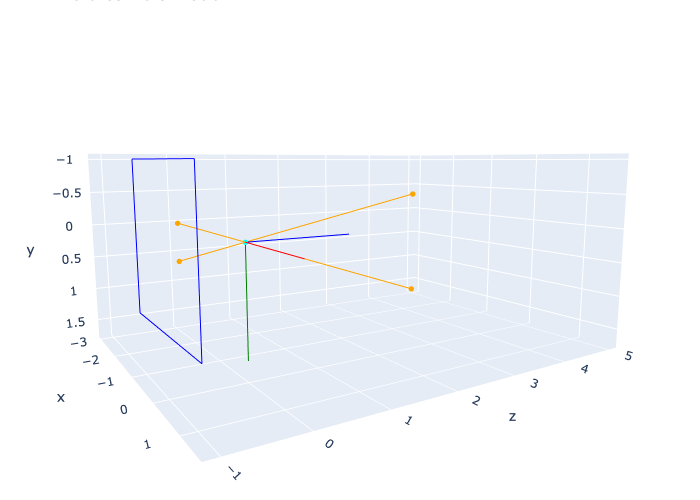

In [ ]:
#| caption: The geometry of the pinhole camera model.
#| label: fig:pinhole_geometry
F = 1 # meter
from gtbook.diffdrive import axes, plane, ray, show_3d
show_3d(go.Figure(data = plane(-F) + [ray(feet, -F), ray(head, -F)] + axes()))

However, it is not easy to debug algorithms with a true *upside down*  pinhole image. Instead, we can define a *virtual image plane* at a distance $F$ *in front* of the pinhole, which is non-physical, but has the advantage that the image now appears right-side up. We simply have to reflect the projected coordinates:
\begin{equation}
X_V = F \frac{X}{Z} ~~~~
Y_V = F \frac{Y}{Z} ~~~~
Z_V = F
\end{equation}
The virtual image geometry, with the virtual image *in front* of the camera, is shown in Figure [3](#fig:virtual_image).

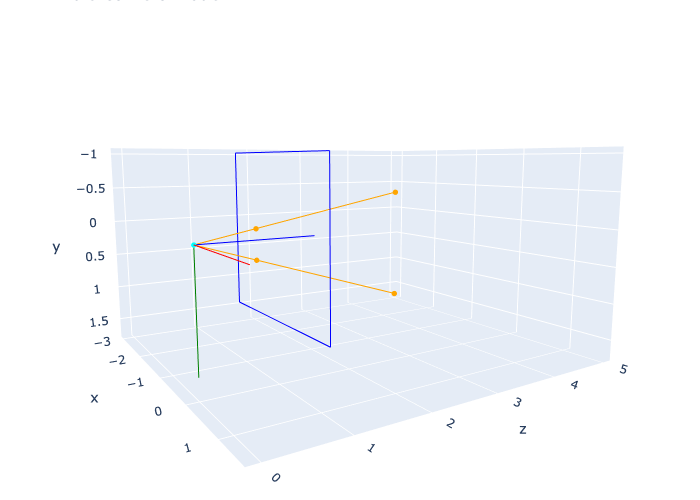

In [ ]:
#| caption: The virtual image is *in front* of the camera.
#| label: fig:virtual_image
show_3d(go.Figure(data = plane(F) + [ray(feet, F), ray(head, F)] + axes()))

```{index} intrinsic camera coordinates, principal point, optical axis
```
The above has the disadvantage that we still have to take into account the focal length $F$ when doing the projection. Dividing by the focal length yields the fundamental *pinhole projection equation*:
\begin{equation}
x = \frac{X}{Z} ~~~~ y = \frac{Y}{Z}
\end{equation}
The dimensionless $x$ and $y$ coordinates are called the **intrinsic camera coordinates**, and can be thought of as the image of the scene in a virtual image plane situated at a focal length of 1.0. 
Note that the image origin at $(x,y)=(0,0)$ is the location where the **optical axis** (the blue z-axis above) pierces the image plane. 
This point is commonly refered to as the **principal point**.
The intrinsic coordinates are in essence measuring a direction in space,
parameterized by a location in the virtual image plane.

## Camera Calibration

> From intrinsic to sensor coordinates.

```{index} sensor coordinates
```
Intrinsic coordinates are dimensionless, but what *pixels* in an image do they correspond to?
Also, when we project real-valued 3D coordinates in an image, we get *real-valued* intrinsic coordinates $(x,y)$. How does that relate to integer pixel coordinates? 
To translate from intrinsic coordinates to pixel coordinates, we introduce real-valued **sensor coordinates** $(u,v)$, with the following conventions (try to draw this out for a $4\times3$ image!):
- the top-left of the sensor corresponds to $(u, v)=(0.0, 0.0)$;
- the bottom-right of the sensor corresponds to $(u, v)=(W, H)$.

Some things to note:
- the vertical $v$-axis points *down*;
- the units are in pixels (*fractional* pixels, if being precise);
- we swapped the convention from $(r,c)\Leftrightarrow(\text{row},\text{column})$ to $(u,v)\Leftrightarrow(\text{horizontal}, \text{vertical})$;
- the middle of pixel $(r, c)=(0, 0)$ has sensor coordinates $(u, v)=(0.5, 0.5)$;
- the middle of pixel $(r, c)=(H-1, W-1)$ has sensor coordinates $(u, v)=(W-0.5, H-0.5)$.


```{index} camera calibration model
```
The simplest **camera calibration model** is just a linear mapping, which is most appropriate for lenses with a small field of view. For this we need four parameters $\alpha$, $\beta$, $u_0$, and $v_0$, to convert from intrinsic coordinates $(x,y)$ to sensor coordinates $(u,v)$:
\begin{equation}
\begin{aligned}
u &= u_0 + \alpha x \\
v &= v_0 + \beta y
\end{aligned}
\end{equation}
As an example, consider the [FireFly S](https://www.flir.com/products/firefly-s/?model=FFY-U3-04S2C-C) machine vision camera, which has the following specifications:
- sensor: [Sony IMX297](https://www.phase1vision.com/userfiles/product_files/imx273_287_296_297_flyer.pdf) (CMOS)
- resolution: 720 x 540
- pixel size: 6.9 $\mu m$ (H) x 6.9 $\mu m$ (V)
- sensor size: 6.3mm diagonally

{raw:tex}`\noindent`
We typically expect the *image center*, corresponding to $(x,y)=(0.0,0.0)$, to be close to $(u_0,v_0)=(W/2,H/2)$. 
For the sensor above this would be $(u_0,v_0)=(364.0, 272.0)$. 
To compute $\alpha$ and $\beta$ we have to take into account the lens focal length $F$. Since $u$ and $v$ are expressed in pixels, and $x$ and $y$ are dimensionless, it is clear that $\alpha$ and $\beta$ must also be expressed in pixels. They can be computed as
\begin{equation}
\begin{aligned}
\alpha = F k &= 8\text{mm}/6.9\mu\text{m} \approx 1160\text{px}\\
\beta = F l &= 8\text{mm}/6.9\mu\text{m} \approx 1160\text{px}
\end{aligned}
\end{equation}
where 
\begin{equation}
k = \text{px}/6.9\mu\text{m}\,\,\,\,\,\mathrm{and}\,\,\,\,l = \text{px}/6.9\mu\text{m}
\end{equation}
are sensor-specific constants that indicated the number of pixels per unit of length.

Whenever $k=l$, the sensor has *square pixels*, and we can just use one proportionality constant, $f=\alpha=\beta$.
In this case, $f$ again denotes the *focal length*, but this time, expressed in pixels. This is a slight abuse of terminology, as $f$ is a property of both the lens *and* the image sensor plane, but its use is in widespread and we will adopt it here as well.

## Pinhole Projection Equations

> From 3D to pixel coordinates.

```{index} pinhole projection
```
Putting all of the above together,
we finally obtain the fundamental **pinhole projection** equation, projecting a point $P$ in 3D camera coordinates $P=(X,Y,Z)$, to its 2D image projection $p=(u,v)$ in sensor coordinates:
\begin{equation}
u = u_0 + f \frac{X}{Z} ~~~~ v = v_0 + f \frac{Y}{Z}.
\end{equation}
To obtain integer pixel coordinates $(r,c)$, we simply need to use the *floor* function, truncating the fractional pixel sensor coordinates to a location in the image array. Note that in doing so we also flip horizontal and vertical:
\begin{equation}
(r,c) = (\lfloor v \rfloor, \lfloor u \rfloor)
\end{equation}
We can also go the other way, *calibrating* the sensor coordinates $(u,v)$ to the dimensionless intrinsic coordinates $(x,y)$:
\begin{equation}
\begin{aligned}
x &= (u-u_0)/f \\
y &= (v-v_0)/f
\end{aligned}
\end{equation}

## Camera Calibration in GTSAM

> Everything above and more.

In GTSAM you have access to several calibration models, with the simple one above corresponding to `Cal3_S2`:

In [ ]:
cal_8mm_FireFlyS = gtsam.Cal3_S2(fx=1160, fy=1160, s=0, u0=364, v0=272)

{raw:tex}`\noindent`
The arguments `fx` and `fy` above correspond to $\alpha$ and $\beta$, and for now you can ignore the extra `s` argument, denoting *skew* which is almost always zero for modern sensors.
We can then convert from integer pixel coordinates to intrinsic coordinates:

In [ ]:
def calibration_demo(cal:gtsam.Cal3_S2, row:int, col:int):
    """Convert from integer pixel coordinates to sensor and then intrinsic coordinates."""
    assert isinstance(row,int) and isinstance(col,int)
    u, v = 0.5+col, 0.5+row
    x, y = cal.calibrate([u,v])
    print(f"image[{row},{col}] -> (u,v)=({round(u,2)}px,{round(v,2)}px) -> (x,y)=({round(x,3)},{round(y,3)}) ")

calibration_demo(cal_8mm_FireFlyS, row=0, col=0)
calibration_demo(cal_8mm_FireFlyS, row=272, col=364)
calibration_demo(cal_8mm_FireFlyS, row=543, col=727)

image[0,0] -> (u,v)=(0.5px,0.5px) -> (x,y)=(-0.313,-0.234) 
image[272,364] -> (u,v)=(364.5px,272.5px) -> (x,y)=(0.0,0.0) 
image[543,727] -> (u,v)=(727.5px,543.5px) -> (x,y)=(0.313,0.234) 


Note that although the intrinsic coordinates are the dimensionless, you can interpret them as fractions of the focal length. 
Also, the above was a "calibration" example where we go from pixel coordinates to intrinsic coordinates. The calibration objects in GTSAM also provide an `uncalibrate` method which goes the other way:

In [ ]:
u,v = cal_8mm_FireFlyS.uncalibrate([0,0])
print(f"(x,y)=(0,0) -> (u,v)=({round(u,2)}px,{round(v,2)}px)")

(x,y)=(0,0) -> (u,v)=(364.0px,272.0px)


## Camera Field of View

```{index} pair: field of view; FOV
```
The last concept we need to define the camera imaging geometry
is the camera's **field of view** or **FOV**.
Because the *left-most* ray we can see has $u=0$, it corresponds to $x=-u_0/f\approx-W/2f$.
The horizontal FOV can then be calculated by
\begin{equation}
\mathrm{HFOV} = 2 \arctan(W/2f)\,\,\mathrm{rad} = 360 \arctan(W/2f) / \pi\,\,\mathrm{degrees}
\end{equation}
For the sensor-lens combination above we get a relatively narrow field of view of about 35 degrees:

In [ ]:
f = 1160
hfov = 360 * math.atan(728/(2*f)) / math.pi
print(f"HFOV for f={f} is {hfov:.2f} degrees")

HFOV for f=1160 is 34.84 degrees


Field of view *increases* with decreasing focal length, e.g., a lens of 4mm will give us a bit less than double that HFOV, of around 64 degrees:

In [ ]:
f_wide = 4e-3/6.9e-6
hfov_wide = 360 * math.atan(728/(2*f_wide)) / math.pi
print(f"HFOV for f={f_wide:.1f} is {hfov_wide:.2f} degrees")

HFOV for f=579.7 is 64.25 degrees


We can also ask the opposite question: what lens focal length should we choose to get a certain filed of view. For example, for a *diagonal* field of view we have
\begin{equation}
\mathrm{DFOV} = 360 \arctan(\sqrt{W^2+H^2}/2f) / \pi~~\mathrm{degrees}
\end{equation}
and hence
\begin{equation}
f = \frac{\sqrt{W^2+H^2}}{2 \tan(\mathrm{DFOV} \pi/360)}
\end{equation}

In [26]:
f45 = math.sqrt(728**2+544**2)/2/math.tan(math.pi/4)
F45 = f45*6.9e-3
print(f"f45 = {np.round(f45)} pixels, F45 = {np.round(F45,1)} mm")


f45 = 454.0 pixels, F45 = 3.1 mm


## Stereo Vision

> Given two cameras, we can calculate depth.

When using two cameras, we can triangulate a feature that is seen in both cameras to calculate its location in space. 
Given a projection $p=(u,v)$ of a point $P=(X,Y,Z)$ in a single camera we can only determine the *ray* on which the point $P$ must lie.
However, if we see *two* projections of the same feature in two cameras, placed side by side, we can *triangulate* the location of $P$.
In particular, let us name the cameras "Left" and "Right", abbreviated as "L" and "R", and let the two projections be $p_L=(u_L,v_L)$ and $p_R=(u_R,v_R)$. How could we recover the coordinates $(X,Y,Z)$ in, say, the *left* camera coordinate frame?

```{index} stereo baseline
```
We can easily work out the answer *if* the cameras have the same calibration *and* the camera pair is in a "stereo" configuration. The latter means that the cameras have exactly the same orientation with respect to the world, and the right camera is displaced only horizontally with respect to the left camera. We call the displacement the **stereo baseline** $B$. In that case we have
\begin{equation}
\begin{aligned}
u_L &= u_0 + f \frac{X}{Z}, \,\,\,\,\, &v_L = v_0 + f \frac{Y}{Z} \\
\\
u_R &= u_0 + f \frac{X-B}{Z}, \,\,\,\,\, &v_R = v_0 + f \frac{Y}{Z}
\end{aligned}
\end{equation}

```{index} disparity, fundamental stereo equation
```
Two interesting things to note: (a) $u_L$ and $u_R$ differ only because the $X$ coordinate of the point $P$, measured in the right camera, is $B$ less than its value in the left camera.
and (b) $v_L$ and $v_R$ have the same value: *corresponding* points in a stereo pair lie on the same scanline in the images. We can use the first fact to calculate the *unknown depth* $Z$, by defining the **disparity** $d$ as the difference of $u_L$ and $u_R$,
\begin{equation}
d \doteq u_L - u_R = f \frac{X}{Z} - f \frac{X-B}{Z},
\end{equation}
and then performing some algebraic manipulation to obtain the **fundamental stereo equation**:
\begin{equation}
Z = B \frac{f}{d}.
\end{equation}
The fraction $f/d$ is dimensionless, as both disparity $d$ and focal length $f$ are expressed in pixels, and hence the resulting depth $Z$ is expressed in the units of the baseline $B$. 
Using this together with the projection equations above,
we can now completely reconstruct the location of the point $P$ in (left) camera coordinates:
\begin{equation}
\begin{bmatrix}X\\Y\\Z\end{bmatrix}
= \begin{bmatrix}Z(u_L-u_0)/f\\Z(v_L-v_0)/f\\B f/d\end{bmatrix}
= B \frac{f}{d} \begin{bmatrix}(u_L-u_0)/f\\(v_L-v_0)/f\\1\end{bmatrix}
\end{equation}
Stereo cameras are used very often on robotics platforms because of this ability to reconstruct the world in 3D, at least in principle. This is akin to our own (human) ability to perceive depth by virtue of having two eyes, a feature we have in common with many animals - primarily predators, who need accurate depth vision to hunt prey. In practice, using a stereo camera is not as easy, as it has to be carefully calibrated and finding *correspondences* between left and right cameras is not always straightforward. However, the latter has been alleviated quite a bit by recent advances in neural networks, which we will discuss below.